# Amazon Redset Workload Forecasting

## What is Redset?
Redset is a dataset released by Amazon in 2024, comprising three months of user query metadata from a selected sample of Amazon Redshift instances. It includes query metadata for **200 provisioned and 200 serverless instances**, offering insights into user interactions with these database services. While not representative of the entire Redshift fleet, Redset serves as a valuable resource for developing **new benchmarks and exploring machine learning techniques**, such as **workload forecasting**, tailored to these specific workloads.

## What we perform in this notebook?

In this notebook, we analyze **Amazon Redset**, a dataset containing query metadata from Amazon Redshift instances, to explore **workload forecasting techniques** for **intelligent resource scaling**. Our primary objectives are:

### 1. Baseline Model Evaluation
- We evaluate **traditional forecasting baselines**, such as:
  - **AutoGluon DeepAR**
  - **Seasonal Naive Models**
- These models establish reference points for **workload prediction**.

### 2. Development of RNN-based Forecasting Models
- We implement **Recurrent Neural Network (RNN)-based models** to improve **forecasting accuracy**.
- These models aim to **capture complex workload patterns** and **improve upon the baselines**.

### 3. Comparison Between Baselines and RNN-based Approaches
- Using the **Redset dataset**, we compare the performance of our **custom RNN models** with:
  - **AutoGluon DeepAR**
  - **Statistical forecasting methods** (e.g., ARIMA, ETS)
- We use metrics such as **Q-error** and **forecast accuracy** to assess improvements.

---

### Reference
For more details on the forecasting methodologies and benchmark comparisons, we refer to the **attached paper: "Forecasting Algorithms for Intelligent Resource Scaling: An Experimental Analysis"**.  
This paper provides insights into **workload forecasting challenges**, evaluation metrics, and strategies for improving predictive accuracy in cloud environments.

In [ ]:
import pandas as pd
from datetime import datetime
from utility.helpers import DataManager
import visualization
from utility.baseline_models import DeepARGluonTS
import matplotlib.pyplot as plt
import seaborn as sns

datamanager = DataManager('provisioned', 96)

ModuleNotFoundError: No module named 'gluonts.model.deepar'

In [ ]:
# Load the data
data = datamanager.load_data()
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [ ]:
# Visualize data
visualization.visualize_data(data)
data

,instance_id,timestamp,query_count,runtime,bytes_scanned
300,96,2024-03-01 13:00:00,243,934635.0,509995.0
481,96,2024-03-01 21:00:00,12,106605.0,44231.0
709,96,2024-03-02 07:00:00,142,149788.0,25368.0
833,96,2024-03-02 13:00:00,286,1072228.0,619022.0
1211,96,2024-03-03 05:00:00,1,22.0,0.0
...,...,...,...,...,...
195477,96,2024-05-29 06:00:00,160,157771.0,26350.0
195511,96,2024-05-29 08:00:00,671,1608614.0,358168.0
195579,96,2024-05-29 11:00:00,37,98990.0,34410.0
195607,96,2024-05-29 12:00:00,71,686389.0,433575.0


In [ ]:
# Split into training and test data:
# Following the approach in the paper (p. 132), for a cluster with N weeks of data, 
# the first train-test split includes N-2 weeks for training and the following week 
# for testing. The second train-test split contains the first N-1 weeks for training 
# and the following week for testing, representing a scenario of re-training a model 
# each week and forecasting for the next week

train1, test1, train2, test2 = datamanager.train_test_split(data)

print(f"train1 shape: {train1.shape}")
print(f"test1 shape: {test1.shape}")
print(f"train2 shape: {train2.shape}")
print(f"test2 shape: {test2.shape}")

print(train1.iloc[-1])
print(test1.iloc[0])
print(train1.iloc[-1])
print(test1.iloc[0])

train1 shape: (1919, 5)
test1 shape: (168, 5)
train2 shape: (2087, 5)
test2 shape: (49, 5)
instance_id                       96
timestamp        2024-05-19 19:00:00
query_count                        5
runtime                      63142.0
bytes_scanned                19952.0
Name: 190201, dtype: object
instance_id                       96
timestamp        2024-05-20 05:00:00
query_count                        4
runtime                       7771.0
bytes_scanned                  794.0
Name: 43254, dtype: object
instance_id                       96
timestamp        2024-05-19 19:00:00
query_count                        5
runtime                      63142.0
bytes_scanned                19952.0
Name: 190201, dtype: object
instance_id                       96
timestamp        2024-05-20 05:00:00
query_count                        4
runtime                       7771.0
bytes_scanned                  794.0
Name: 43254, dtype: object


## Baseline Model: DeepAR

In [ ]:
print("Train1 shape:", train1.shape[0])

Train1 shape: 1919


In [ ]:
# Initialize the model with prediction length
model = DeepARModel(prediction_length=24)

print("Model Initialized.")

Initializing DeepARModel...
Model Initialized.


In [ ]:
# Train the model on first training set
trained_model = model.train(train1, target_column='query_count')

# Make predictions
predictions1 = model.predict(test1)
metrics1 = model.evaluate(test1)

# Make predictions for second split
predictions2 = model.predict(test2)
metrics2 = model.evaluate(test2)

# Print evaluation metrics
print("First Split Metrics:", metrics1)
print("Second Split Metrics:", metrics2)

# Save the trained model
model.save_model("models/deepar_model.pkl")
print("Model Training & Prediction Completed.")

/Users/sagnikdas/GitHub/g8/.pyenv/lib/python3.11/site-packages/autogluon/timeseries/predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training...
AutoGluon will save models to '/Users/sagnikdas/GitHub/g8/AutogluonModels/ag-20250215_120457'


Training started...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.10
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.63 GB / 8.00 GB (20.4%)
Disk Space Avail:   61.92 GB / 228.27 GB (27.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'batch_size': 32,
                                'context_length': 24,
                                'dropout': 0.1,
                                'epochs': 50,
                                'hidden_size': 40,
                                'learning_rate': 0.001,
                                'num_layers': 2}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,

Training completed. Models trained: <bound method TimeSeriesPredictor.model_names of <autogluon.timeseries.predictor.TimeSeriesPredictor object at 0x103639c90>>
Test Data Index Type: <class 'pandas.core.indexes.base.Index'>
Predictions Index Type: <class 'pandas.core.indexes.multi.MultiIndex'>


ValueError: cannot include dtype 'M' in a buffer

ValueError: x and y must have same first dimension, but have shapes (168,) and (24,)

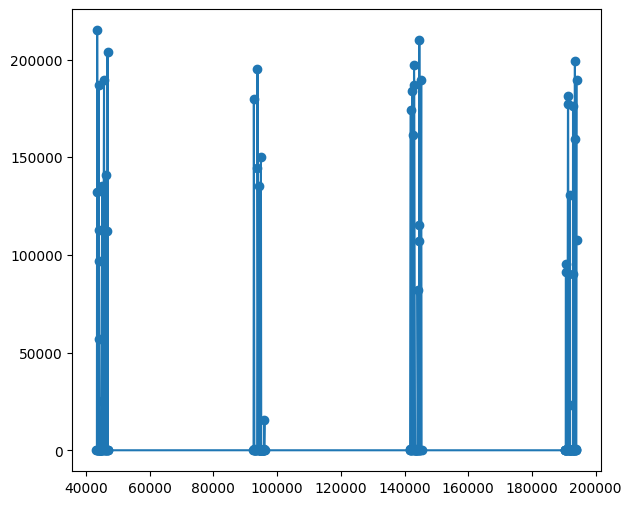

In [ ]:
# 📊 Plot Predictions
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(test1.index, test1['query_count'], label='Actual', marker='o')
plt.plot(test1.index, predictions1['mean'], label='Predicted', marker='o')
plt.fill_between(test1.index, predictions1['0.1'], predictions1['0.9'], alpha=0.3, label='80% Confidence Interval')
plt.title('First Split Predictions')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(test2.index, test2['query_count'], label='Actual', marker='o')
plt.plot(test2.index, predictions2['mean'], label='Predicted', marker='o')
plt.fill_between(test2.index, predictions2['0.1'], predictions2['0.9'], alpha=0.3, label='80% Confidence Interval')
plt.title('Second Split Predictions')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Perform cross-validation on the training set
best_params = model.cross_validate(train1, target_column='query_count')

# Print best hyperparameters and RMSE
print(f"Best Hyperparameters: {best_params['best_params']}")
print(f"Best RMSE Score: {best_params['best_score']:.4f}")

print("Cross-Validation Completed.")

In [ ]:
# visualize first prediction
visualization.visualize_prediction(train1, test1, prediction1)

# visualize first prediction
visualization.visualize_prediction(train2, test2, prediction2)

NameError: name 'prediction1' is not defined